# Spatial Interpolation

<img src="images/interpol.png" width=500 />

Spatial interpolation is the process of using observations with known values to estimate values at unkown locations.For example if we have precipitation data from different weather stations and we want to create a continous map for the entire area. Fortunatley in this case we can generally safely assume that values at nearby locations will be similar (spatial autocorrelation).

There are many interpolation tools available, but these tools can usually be grouped into two categories: 

- deterministic: using mathematical functions, based on either the extent of similarity (IDW) or the degree of smoothing (RBF)
- geostatistical: use both mathematical and statistical methods to predict values at all locations within region of interest and to provide probabilistic estimates of the quality of the interpolation based on the spatial autocorrelation among data points



## Example: Temperature in Burkina Faso

In this example we will take temperature data from different weather stations and try to interpolate the missing data in order to create a map showing the mean temperature in Burkina Faso for 2019. The data set we are using contains measurements from weather stations located in Burkina Faso and the neighbouring countries for the year 2019. Station data is derived from the GSOD (Global Surface Summary of the Day) dataset. 
Global Surface Summary of the Day is derived from The Integrated Surface Hourly (ISH) dataset. The ISH dataset includes global data obtained from the USAF Climatology Center, located in the Federal Climate Complex with NCDC. The latest daily summary data are normally available 1-2 days after the date-time of the observations used in the daily summaries. 



In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

ws = gpd.read_file('Data/vector/ws.shp')
region = gpd.read_file('Data/vector/reg.shp')

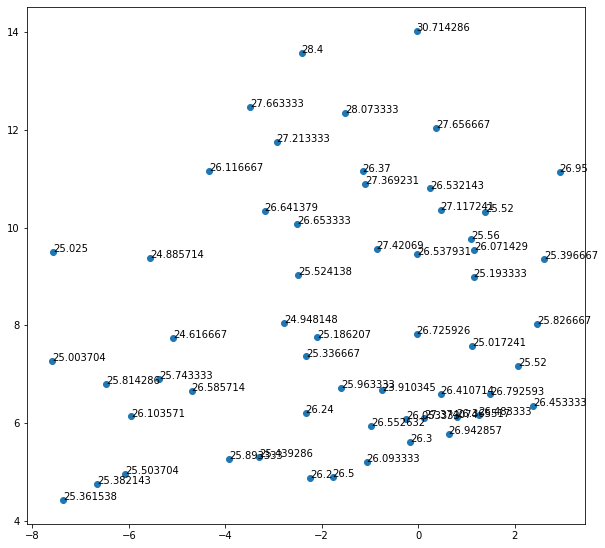

In [2]:
ws = ws.round(6)
ws['coords'] = ws['geometry'].apply(lambda x: x.representative_point().coords[:])
ws['coords'] = [coords[0] for coords in ws['coords']]
ws.plot(figsize=(10,10))
for idx, row in ws.iterrows():
    plt.annotate(s=row['mean_temp'], xy=row['coords'],
                 horizontalalignment='left')

In [4]:
import mplleaflet
%matplotlib inline
ax = ws.plot(column='mean_temp', colormap='RdBu_r')
region.plot(ax=ax)
mplleaflet.display(fig=ax.figure, tiles='cartodb_positron')

/home/sth02bh/.local/lib/python3.8/site-packages/geopandas/plotting.py:558: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(
/home/sth02bh/.local/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Deterministic methods

In this course we will have a look at 2 deterministic methods: 
- Thiessen polygons 
- Inverse Distance Weighted

## Voronoi polygons

A Voronoi diagram, also called Thiessen polygons or Dirichlet decomposition, is a decomposition of space into regions determined by a given set of points in space, here called centers. Each region is defined by exactly one centre and includes all points of space which, in terms of Euclidean metrics, are closer to the centre of the region than to any other centre. Such regions are also called Voronoi regions. The Voronoi diagram is formed from all points that have more than one nearest centre and thus form the boundaries of the regions. 


<img src="images/voronoi.png" width=200 />

In [ ]:
import geopandas
import geoplot
# Import shapely to convert string lat-longs to Point objects
from shapely.geometry import Point

ax = geoplot.voronoi(ws,  # Define the GeoPandas DataFrame
                     hue='mean_temp',  # df column used to color regions
                     clip=region,  # Define the voronoi clipping (map edge)
                     #projection=proj,  # Define the Projection
                     cmap='RdBu_r',  # color set  # No. of discretized buckets to create
                     legend=True, # Create a legend
                     edgecolor='white',  # Color of the voronoi boundaries
                     linewidth=0.01  # width of the voronoi boundary lines
                    )
geoplot.polyplot(region,  # Base Map
                 ax=ax,  # Axis attribute we created above
                 extent=region.total_bounds,  # Set plotting boundaries to base map boundaries
                 edgecolor='black',  # Color of base map's edges
                 linewidth=1,  # Width of base map's edge lines
                 zorder=1  # Plot base map edges above the voronoi regions
                 )

In [ ]:
import numpy as np
from libpysal.cg.voronoi  import voronoi, voronoi_frames

x = ws['geometry'].apply(lambda x: x.x)
y = ws['geometry'].apply(lambda x: x.y)
data=np.column_stack((x, y))
region_df, point_df = voronoi_frames(data)
region_df['mean_temp'] = ws['mean_temp']
region_df.plot(column='mean_temp', colormap='RdBu_r')

In [ ]:
vo_clip = gpd.clip(region_df,region)
vo_clip.plot(column='mean_temp', colormap='RdBu_r')

In [ ]:
ax = ws.plot(column='mean_temp', colormap='RdBu_r')
vo_clip.plot(ax=ax, column='mean_temp', colormap='RdBu_r')
mplleaflet.display(fig=ax.figure, tiles='cartodb_positron')

## IDW

Probably one of the oldest spatial prediction technique is the inverse distance interpolation. IDW is a simple non-statistical interpolation method and is based on the principle of spatial correlation - i.e. things that are closer to each other are more similar in value. IDW uses only the distance between the individual measuring points and the point to be calculated as the influencing factor for the interpolation, i.e. the greater the distance, the smaller the influence of the measuring point on the calculation of a value for a non-sampled location.



$$\hat{P} = \frac{\sum_{i=1}^n \frac{P_i}{d_i²}}{\sum_{i=1}^n\frac{1}{d_i²}}$$

The measure closest to the prediction location have more influence on the predicted value than those farther away. IDW assumes that each measurement influences the surrounding and that influence becomes weaker with increasing distance. The idea is give greater weights to observations close to the location we want to predict. With increasing distance to the observation the smaller weights are assigned, hence the name inverse distance weighted

<img src="images/idw_calc.png"  width=120 />

$$\hat{P} = \frac{\frac{10}{25²} + \frac{20}{15²} +\frac{30}{10²}}{\sum_{i=1}^n\frac{1}{25²}\frac{1}{15²}\frac{1}{10²}} = 25.24$$ 

In [ ]:
import skspatial
import numpy as np

In [ ]:
ulc = (region.bounds.minx.min(),region.bounds.maxy.max())
lrc = (region.bounds.maxx.max(),region.bounds.miny.min())

In [ ]:
res = 00.1
ml = skspatial.interp2d(ws,'mean_temp',res=res, ulc=ulc, lrc=lrc)

In [ ]:
array = ml.knn_2D(k=10, weights='distance')

In [ ]:
ax = ml.plot_image(array)
CS = plt.contour(np.flipud(array),extent=ml.extent)
region.boundary.plot(ax=ax, color='red')
plt.clabel(CS, inline=1,
           fmt='%1.1f',
           fontsize=14)


##  Statistical Approach 

## Trend Surfaces

This interpolation methods fits a polynomial surface by least-squares regression through the sample data points.The result is a surface that minimizes the variance of the surface in relation to the input values. In this section we will explore a 0th order, 1st order and 2nd order surface trend.

<img src="images/surface_trend.png" width=600 />

The first order surface polynomial is a flat plane whose formula is given by: 
$$Z = a + bX + cY$$

Adding a term to the mathematical formula allows us to add another bend in the plane.
- first-order polynomial (linear).
<img src="images/surface_trend1.png" width=150 />
- second-order polynomial (quadratic) 
<img src="images/surface_trend2.png" width=150 />
- third-order (cubic)
<img src="images/surface_trend3.png" width=150 />
- fourth-oder (quartic)
<img src="images/surface_trend4.png" width=150 />

In [ ]:
import pandas as pd
import cartopy.crs as ccrs
import verde as vd

ws['longitude'] = ws['geometry'].apply(lambda x: x.x)
ws['latitude'] = ws['geometry'].apply(lambda x: x.y)

coordinates = (ws.longitude.values, ws.latitude.values)

trend = vd.Trend(degree=3).fit(coordinates, ws.mean_temp)

ws["trend"] = trend.predict(coordinates)
ws["residual"] = ws.mean_temp - ws.trend


In [ ]:
grid = trend.grid(spacing=0.1, dims=["latitude", "longitude"])
grid

In [ ]:
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Temperature gridded")
ax.plot(*coordinates, ".k", markersize=1, transform=ccrs.PlateCarree())
tmp = ax.pcolormesh(
    grid.longitude,
    grid.latitude,
    grid.scalars,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp).set_label("temperature (C)")
plt.tight_layout()
plt.show()

In [ ]:
residuals = ws.mean_temp - ws.trend
fig, axes = plt.subplots(
    1, 2, figsize=(10, 6), subplot_kw=dict(projection=ccrs.Mercator())
)

ax = axes[0]
ax.set_title("Trend")
tmp = ax.scatter(
    ws.longitude,
    ws.latitude,
    c=ws.trend,
    s=60,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.06)

ax = axes[1]
ax.set_title("Residuals")
tmp = ax.scatter(
    ws.longitude,
    ws.latitude,
    c=residuals,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.08)
plt.tight_layout()
plt.show()


In [ ]:
train, test = vd.train_test_split(
    coordinates, ws.mean_temp, test_size=0.2, random_state=0,
)

trend = vd.Trend(degree=3).fit(*train)

test_values = np.array(list(test[1]))
prediction = trend.predict(test[0])

df = pd.DataFrame({'obs':test_values[0], 'pred':prediction})

correlation_matrix = np.corrcoef(test_values[0], prediction)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats


p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

In [ ]:
scores = vd.cross_val_score(vd.Trend(degree=3), coordinates, ws.mean_temp)
print("k-fold scores:", scores)
print("Mean score:", np.mean(scores))

## Spline inerpolation

The spline method works a little bit like the trend surface. You can think of a rubber disc passing through the points, which is bent while the overall curvature of the surface is minimized. It adjusts a mathematical function according to a specified number of next input points as it passes through the reference points. This method is best suited for generating smoothly changing surfaces, e.g. heights, water levels or pollutant concentrations.

The basic form of the spline method with minimal curvature imposes the following two conditions on the interpolant:

   - The surface must pass exactly through the data points.
   - The surface must have minimal curvature. The total sum of the squares of the second derivative values of the surface, measured over all points of the surface, must be a minimum.

<img src="images/Spline_interpolation.png" width=600 />

In [ ]:
coordinates = (ws.longitude.values, ws.latitude.values)
spline = vd.Spline().fit(coordinates, ws.mean_temp)
grid = spline.grid(spacing=0.1, dims=["latitude", "longitude"])

plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Temperature gridded")
ax.plot(*coordinates, ".k", markersize=1, transform=ccrs.PlateCarree())
tmp = ax.pcolormesh(
    grid.longitude,
    grid.latitude,
    grid.scalars,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp).set_label("temperature (C)")
plt.tight_layout()
plt.show()

In [ ]:
train, test = vd.train_test_split(
    coordinates, ws.mean_temp, test_size=0.2, random_state=0,
)

spline = vd.Spline().fit(*train)

test_values = np.array(list(test[1]))
prediction = spline.predict(test[0])

df = pd.DataFrame({'obs':test_values[0], 'pred':prediction})

correlation_matrix = np.corrcoef(test_values[0], prediction)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [ ]:
p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

In [ ]:
scores = vd.cross_val_score(vd.Spline(), coordinates, ws.mean_temp)
print("k-fold scores:", scores)
print("Mean score:", np.mean(scores))

## Kriging

The Kriging method assumes that the distance or direction between reference points reflects a spatial correlation that can be used to explain variations on the surface. The Kriging tool fits a mathematical function to a specified number of points or all points within a specified radius to determine the output value for each location. 

"Kriging" is a multi-step process that includes: preliminary statistical analysis of the data, variogram modeling, creation of the surface, and (optionally) examination of a variance surface. In geostatistics the spatial correlation is modelled by the variogram instead of a correlogram or covariogram, largely for historical reasons. 

The main idea of kriging is that close sample points get more weight in a prediction to improve the estimate.  Kriging relies on the knowledge of some kind of spatial structure, which is modeled via the second-order properties, i.e.  variogram or covariance, of the underlying random function Z(x).Thus, the kriging process is best used when you know that the data has a spatially correlated distance or directional trend.Several forms of kriging interpolators exist (e.g. ordinary, universal and simple). A standard version of kriging is called ordinary kriging.

$$\gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2$$

<img src="images/variogram.png" width=500 />

   - Sill: The value at which the model first flattens out. 
   - Range: The distance at which the model first flattens out
   - Nugget: The value at which the semi-variogram (almost) intercepts the y-value

In [ ]:
import numpy as np
import pandas as pd
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

region = gpd.read_file('Data/vector/reg.shp')

In [ ]:
from shapely.ops import cascaded_union
boundary = cascaded_union(region.geometry)
xmin, ymin, xmax, ymax = boundary.bounds

In [ ]:
xmin = xmin-0.01
xmax = xmax+0.01

ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

In [ ]:
OK = OrdinaryKriging(ws.longitude,ws.latitude,ws.mean_temp, variogram_model='gaussian', verbose=True, enable_plotting=True,nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)


In [ ]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))

boundarygeom = region.geometry
contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 
plt.colorbar(contour)

region.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)
npts = len(ws.longitude)

plt.scatter(ws.longitude, ws.latitude,marker='o',c='b',s=npts)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Spatial interpolation from temperature (%d points)' % npts,fontsize = 40)
plt.show()

In [ ]:
np.random.seed(0)
test_indexes = np.random.choice(a=ws.index, size=int(np.round(len(ws.index.values)/4)))
train_indexes = [index for index in ws.index if index not in test_indexes]
ws_test = ws.loc[test_indexes,:].copy()
ws_train = ws.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(ws_train), len(ws_test)))

In [ ]:
model = OrdinaryKriging(ws_train.longitude,ws_train.latitude,ws_train.mean_temp, variogram_model='gaussian', verbose=True, enable_plotting=True,nlags=20)
ws_test['prediction'] = model.execute(style='points', xpoints=ws_test.longitude, ypoints=ws_test.latitude )[0].data


In [ ]:
df = pd.DataFrame({'obs':ws_test['mean_temp'] , 'pred':ws_test['prediction']})

correlation_matrix = np.corrcoef(ws_test['mean_temp'], ws_test['prediction'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
df

In [ ]:
p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)
ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

# Literatur

Bivand, Roger S., et al. Applied spatial data analysis with R. Vol. 747248717. New York: Springer, 2008.

https://rspatial.org/raster/analysis/

https://mgimond.github.io/Spatial/introGIS.html

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html

https://github.com/WZBSocialScienceCenter/geovoronoi

https://github.com/rosskush/skspatial

https://github.com/fatiando/verde